# EDA & Preproessing

For loading data from huggingface

In [ ]:
!pip install datasets --quiet

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt, seaborn as sns, pandas as pd, os
from tensorflow.keras.utils import text_dataset_from_directory, plot_model
import tensorflow as tf

Importing our raw dataset

In [ ]:
df_raw  = pd.DataFrame(load_dataset("Fatima0923/Automated-Personality-Prediction", split='all'))

In [ ]:
df_raw.head(5)

,text,agreeableness,openness,conscientiousness,extraversion,neuroticism
0,his name was kim kimble originally wow thats s...,9.0,61.0,13.0,4.0,72.0
1,theyre better than the normal posts on ryugioh...,50.0,85.0,50.0,85.0,50.0
2,how the fuck does this even happen hi youre cu...,15.0,85.0,15.0,85.0,15.0
3,it probably does ive learned a lot about mysel...,71.0,53.0,17.0,3.0,31.0
4,yea those are the same sound to me still,64.0,44.0,33.0,8.0,88.0


At first look it seems there are 20,877 texts in the data

In [ ]:
print('Number of records:', df_raw.shape[0])

Number of records: 20877


## Removing duplicates

As we look closer at the data, we spot several records that repeats tens of times with the same scores

For example, the sentence 'gop math wrong wrong right' repeats 20 times in the complete dataset

In [ ]:
df_raw[df_raw['text'] == 'gop math wrong wrong right'].reset_index()

,index,text,agreeableness,openness,conscientiousness,extraversion,neuroticism
0,646,gop math wrong wrong right,10.0,80.0,74.0,27.0,18.0
1,933,gop math wrong wrong right,10.0,80.0,74.0,27.0,18.0
2,1923,gop math wrong wrong right,10.0,80.0,74.0,27.0,18.0
3,2712,gop math wrong wrong right,10.0,80.0,74.0,27.0,18.0
4,2718,gop math wrong wrong right,10.0,80.0,74.0,27.0,18.0
5,3233,gop math wrong wrong right,10.0,80.0,74.0,27.0,18.0
6,5737,gop math wrong wrong right,10.0,80.0,74.0,27.0,18.0
7,7396,gop math wrong wrong right,10.0,80.0,74.0,27.0,18.0
8,8098,gop math wrong wrong right,10.0,80.0,74.0,27.0,18.0
9,8182,gop math wrong wrong right,10.0,80.0,74.0,27.0,18.0


We'll remove duplicates from data

In [ ]:
df_raw_uniques = df_raw.drop_duplicates()

After removing duplicates, in the complete dataset there are 17,009 non-repeating records

In [ ]:
print("Number of unique records in the complete dataset:", df_raw_uniques.shape[0])

Number of unique records in the complete dataset: 17009


## Preproccess text and label

Preproccess the texts: remove punctuation and stop words from them

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

text_for_model=[]
for sentence in df_raw_uniques['text']:
  cleaned_words = []
  words = word_tokenize(sentence)
  cleaned_words.extend([word.lower() for word in words if word.lower() not in stop_words and word.lower() not in punctuations])
  text_for_model.append(' '.join(cleaned_words))

df = pd.DataFrame({'text': text_for_model})

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In this work there will be an attempt to classify the **extraversion**

Other traits will be dropped and the numerical values of extraversion will be replaced by 2 categorical labels: 'Introverted', 'Extroverted'.
*   Introverted -> under 50 points
*   Extroverted -> equal to or above 50 points  




In [ ]:
def float_to_lable(df):
  bins = [-1, 50, 100]
  lables = ['Introverted', 'Extroverted']
  s = pd.cut(df['extraversion'], bins=bins, labels=lables).to_list()
  return s

df['lable']=float_to_lable(df_raw_uniques)
df.head(5)

,text,lable
0,name kim kimble originally wow thats messed pa...,Introverted
1,theyre better normal posts ryugioh id rather t...,Extroverted
2,fuck even happen hi youre cute ive crush awhil...,Extroverted
3,probably ive learned lot browsing subreddit mo...,Introverted
4,yea sound still,Introverted


## Splitting data and choosing a model

Split data again to train, validation and test sets

We'll keep the proportions between the lables the same in the datasets

In [ ]:
from sklearn.model_selection import train_test_split

train, val_test = train_test_split(df, test_size=0.4, shuffle=True, stratify=df['lable'])
validation, test = train_test_split(val_test, test_size=0.4, shuffle=True, stratify=val_test['lable'])

Based on the finger rule of choosing a model: We'll use BoW to classify the texts

In [ ]:
word_count = [len(x.split()) for x in train['text']]

num_samples = len(train['text'])
mean_sample_length = sum(word_count)/len(word_count)

ratio = num_samples / mean_sample_length
print("Ratio between number of samples and mean sample size:", ratio)

Ratio between number of samples and mean sample size: 407.5115630233687


## Data Statistics

Most common words are: 'like', 'dont', 'people'

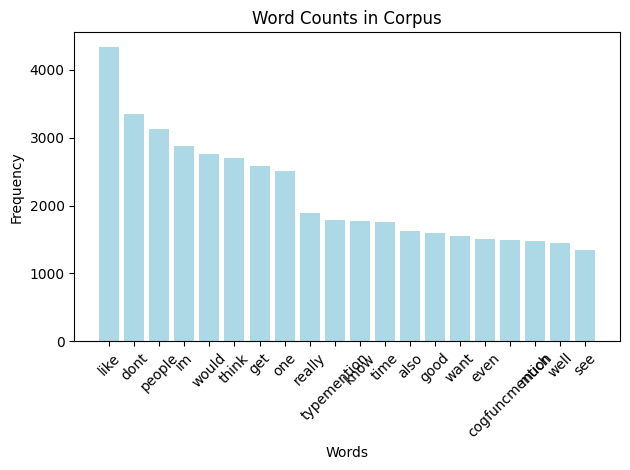

In [ ]:
from collections import Counter
from nltk.tokenize import word_tokenize

corpus = list(df['text'])
words = []
for sentence in corpus:
  words.extend(word_tokenize(sentence))
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)
plt.bar(*zip(*most_common_words), color='lightblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Counts in Corpus')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


There are many more texts labled as Introverted than extroverted.

We'll keep that in mind when analysing prediction results

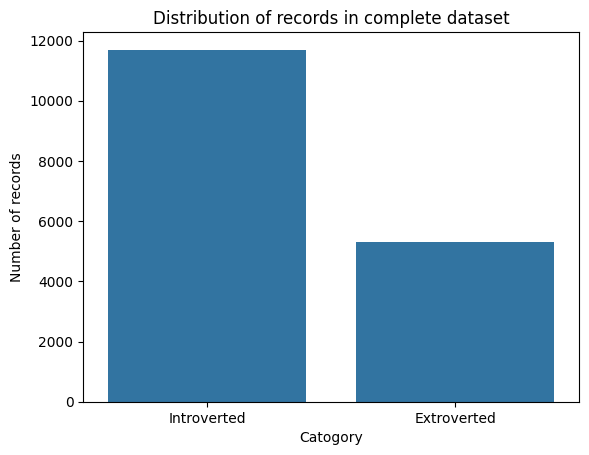

In [ ]:
import matplotlib.pyplot as plt
sns.countplot(x = df['lable'])
plt.xlabel('Catogory')
plt.ylabel('Number of records')
plt.title('Distribution of records in complete dataset')
plt.show()


## Uploading data to files

Transform the datasets to batch datasets


In [ ]:
from os.path import join
root_dir = "/content/Data"

def data_to_folders(df, num):
  for index, row in df.iterrows():
    # Create category subfolder if it doesn't exist
    if num == 1:
      name = 'train'
    elif num == 2:
      name = 'validation'
    elif num == 3:
      name = 'test'
    category_dir = join(root_dir, join(name, row['lable']))
    if not os.path.exists(category_dir):
      os.makedirs(category_dir)

    text_file_path = os.path.join(category_dir, f'text_{index}.txt')
    with open(text_file_path, 'w') as text_file:
      text_file.write(row['text'])

data_to_folders(train, 1)
data_to_folders(validation, 2)
data_to_folders(test, 3)

train_ds = text_dataset_from_directory("/content/Data/train",
                                       batch_size=32)
validation_ds = text_dataset_from_directory("/content/Data/validation",
                                            batch_size=32)
test_ds = text_dataset_from_directory("/content/Data/test",
                                      batch_size=32)

Found 15905 files belonging to 2 classes.
Found 9558 files belonging to 2 classes.
Found 6932 files belonging to 2 classes.


# Random model

Before preparing a model, especially a deep learning model, it's important to define the baseline

For that We'll shuffle the whole data and calculate accuracy of forecasting

where:
*   train set = original
*   test set = shuffled

Without any sofisticated model, we get 57% accuracy

In [ ]:
import random
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

original_labels = df['lable']
shuffled_labels = original_labels.copy()
random.shuffle(shuffled_labels)

accuracy = accuracy_score(original_labels, shuffled_labels)
print("Accuracy of Random Prediction:", accuracy)

Accuracy of Random Prediction: 0.568346169674878


In [ ]:
cm = confusion_matrix(original_labels, shuffled_labels)
pd.DataFrame(cm, index = ['Introverted', 'Extroverted'], columns = ['Predicted Introverted', 'Predicted Extroverted'])


,Predicted Introverted,Predicted Extroverted
Introverted,1644,3671
Extroverted,3671,8023


# Bag of Words

Now we'll see if BoW can beat our random model and by how much.

We'll call CountVectorizer and define the minimum number of features to be atleast 200

Then fit on the train data and transform

Also transform the validation data

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf

Transforming the batch dataset to datasets in order to tokenize

Also, changing the labels to:


*   Introverted -> 1
*   Extroverted -> 0

In [ ]:
def get_texts_and_labels(datasetBatch):
    texts = []
    labels = []
    for text, label in datasetBatch:
        texts.extend(text.numpy())
        labels.extend(label.numpy())
    return texts, labels

train_texts, train_labels = get_texts_and_labels(train_ds)
val_texts, val_labels = get_texts_and_labels(validation_ds)
test_texts, test_labels = get_texts_and_labels(test_ds)


Vectorizing texts. The model will use the 1000 most common words to predict

In [ ]:
for num_tokens in [500, 1000, 2000]:
    vectorizer = keras.layers.TextVectorization(max_tokens=1000, output_mode='tf-idf')
    vectorizer.adapt(train_texts)

    X_train = vectorizer(train_texts)
    X_val = vectorizer(val_texts)
    X_test = vectorizer(test_texts)

    y_train = np.array(train_labels)
    y_val = np.array(val_labels)
    y_test = np.array(test_labels)




Defining the nn layers for binary classification


In [ ]:
def build_BoW_model(dense1_units, dense2_units):
    inputs = keras.layers.Input(shape=(X_train.shape[1],), name='input_layer')
    net = keras.layers.Dense(dense1_units, activation='relu', input_shape=(X_train.shape[1],), name='dense1')(inputs)
    net = keras.layers.Dropout(0.3, name='dropout1')(net)
    net = keras.layers.Dense(dense2_units, activation='relu', name='dense2')(net)
    net = keras.layers.Dropout(0.3, name='dropout2')(net)
    outputs = keras.layers.Dense(1, activation='sigmoid', name='sigmoid')(net)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

# Trying different hyperparams

Trying different sizes of layers

In [ ]:
for dense1 in [32, 256]:
    for dense2 in [32, 128]:
            BoW_model = build_BoW_model(dense1, dense2)
            BoW_model.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

            history = BoW_model.fit(X_train, y_train, verbose=0,
                                batch_size=32, epochs=10,
                                validation_data=(X_val, y_val))
            print(dense1, dense2, "Accuracy:", BoW_model.evaluate(X_test, y_test)[1])

217/217 [==============================] - 0s 2ms/step - loss: 0.4510 - accuracy: 0.7858
32 32 Accuracy: 0.7857761383056641
217/217 [==============================] - 0s 2ms/step - loss: 0.4390 - accuracy: 0.7962
32 128 Accuracy: 0.7961627244949341
217/217 [==============================] - 0s 2ms/step - loss: 0.3950 - accuracy: 0.8139
256 32 Accuracy: 0.8139064908027649
217/217 [==============================] - 0s 2ms/step - loss: 0.3573 - accuracy: 0.8368
256 128 Accuracy: 0.8368436098098755


We'll choose 256 neurons in first dense layer and 128 neurons in second dense layer.

In [ ]:
BoW_model = build_BoW_model(256, 128)
BoW_model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

Checking best max_tokens, ngrams

Trying different ngrams:

In [ ]:
vectorizer = keras.layers.TextVectorization(max_tokens=1000, output_mode='tf_idf', ngrams=1)
vectorizer.adapt(train_texts)

X_train = vectorizer(train_texts)
X_val = vectorizer(val_texts)
X_test = vectorizer(test_texts)

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

history = BoW_model.fit(X_train, y_train, verbose=0,
                        batch_size=32, epochs=10,
                        validation_data=(X_val, y_val))
print("Best Accuracy:", BoW_model.evaluate(X_test, y_test)[1])

217/217 [==============================] - 0s 2ms/step - loss: 0.3518 - accuracy: 0.8426
Best Accuracy: 0.842613935470581


1000 tokens and 2-grams

In [ ]:
vectorizer = keras.layers.TextVectorization(max_tokens=1000, output_mode='tf_idf', ngrams=2)
vectorizer.adapt(train_texts)

X_train = vectorizer(train_texts)
X_val = vectorizer(val_texts)
X_test = vectorizer(test_texts)

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

history = BoW_model.fit(X_train, y_train, verbose=0,
                        batch_size=32, epochs=10,
                        validation_data=(X_val, y_val))
print(ngrams,  "Accuracy:", BoW_model.evaluate(X_test, y_test)[1])

217/217 [==============================] - 0s 2ms/step - loss: 0.5037 - accuracy: 0.7582
1 Accuracy: 0.758222758769989


**Our best model:** 87% accuracy

Trying feeding 2000 tokens with 1-grams to the nn

In [ ]:
vectorizer = keras.layers.TextVectorization(max_tokens=2000, output_mode='tf_idf', ngrams=1)
vectorizer.adapt(train_texts)

X_train = vectorizer(train_texts)
X_val = vectorizer(val_texts)
X_test = vectorizer(test_texts)

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

history = BoW_model.fit(X_train, y_train, verbose=1,
                        batch_size=32, epochs=10,
                        validation_data=(X_val, y_val))
print("Accuracy:", BoW_model.evaluate(X_test, y_test)[1])

Epoch 1/10
498/498 [==============================] - 6s 11ms/step - loss: 0.6621 - accuracy: 0.6738 - val_loss: 0.5820 - val_accuracy: 0.7058
Epoch 2/10
498/498 [==============================] - 6s 11ms/step - loss: 0.5901 - accuracy: 0.7008 - val_loss: 0.5300 - val_accuracy: 0.7380
Epoch 3/10
498/498 [==============================] - 5s 9ms/step - loss: 0.5406 - accuracy: 0.7307 - val_loss: 0.4810 - val_accuracy: 0.7558
Epoch 4/10
498/498 [==============================] - 5s 10ms/step - loss: 0.4917 - accuracy: 0.7578 - val_loss: 0.4242 - val_accuracy: 0.8025
Epoch 5/10
498/498 [==============================] - 5s 11ms/step - loss: 0.4322 - accuracy: 0.7905 - val_loss: 0.3782 - val_accuracy: 0.8299
Epoch 6/10
498/498 [==============================] - 5s 10ms/step - loss: 0.3790 - accuracy: 0.8223 - val_loss: 0.3402 - val_accuracy: 0.8466
Epoch 7/10
498/498 [==============================] - 6s 11ms/step - loss: 0.3265 - accuracy: 0.8454 - val_loss: 0.3144 - val_accuracy: 0.8571


Worst results so far: 78% accuracy

In [ ]:
vectorizer = keras.layers.TextVectorization(max_tokens=500, output_mode='tf_idf', ngrams=1)
vectorizer.adapt(train_texts)

X_train = vectorizer(train_texts)
X_val = vectorizer(val_texts)
X_test = vectorizer(test_texts)

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

history = BoW_model.fit(X_train, y_train, verbose=0,
                        batch_size=32, epochs=10,
                        validation_data=(X_val, y_val))
print("Accuracy:", BoW_model.evaluate(X_test, y_test)[1])

217/217 [==============================] - 0s 2ms/step - loss: 0.4383 - accuracy: 0.7874
Accuracy: 0.7873629331588745


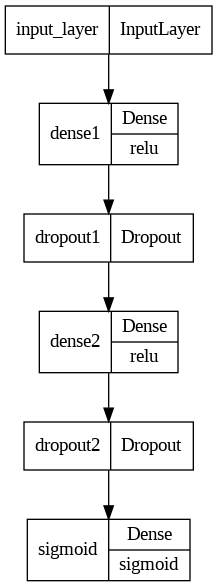

In [ ]:
plot_model(BoW_model, show_layer_names=True, show_layer_activations=True)